In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from sklearn.utils import shuffle
from tensorflow.keras import utils
from tensorflow import concat
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix

2023-10-13 00:48:03.152971: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 00:48:03.224689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:48:04.375293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class SeBlock(Model):
    def __init__(self, planes):
        super(SeBlock, self).__init__()
        self.se = Sequential()
        self.se.add(GlobalAveragePooling2D(keepdims=True))
        self.se.add(Conv2D(planes,kernel_size=(1,1),strides=(1, 1),padding='same'))
        self.se.add(Activation('gelu'))
        self.se.add(Conv2D(planes,kernel_size=(1,1),strides=(1, 1),padding='same'))
        self.se.add(Activation('sigmoid'))
    def call(self, inputs):
        out = self.se(inputs)
        return out

In [3]:
class BasicBlock(Model):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.basic = Sequential()
        self.basic.add(Conv2D(planes,kernel_size=(3,3),strides=(stride, stride),padding='same')) 
        self.basic.add(BatchNormalization())
        self.basic.add(Activation('gelu'))
        self.basic.add(Conv2D(planes,kernel_size=(3,3),strides=(1, 1),padding='same'))
        self.basic.add(BatchNormalization())
        self.se1 = SeBlock(planes=planes)
        self.shortcut = Sequential()
        if in_planes!=planes or stride!=1:
            self.shortcut.add(Conv2D(planes,kernel_size=(1,1),strides=(stride, stride),padding='same'))
            self.shortcut.add(BatchNormalization())
        self.a2 = Activation('gelu')
    def call(self, inputs):
        out = self.basic(inputs)
        w = self.se1(out)
        out = out * w
        residual=self.shortcut(inputs)
        out = self.a2(residual+out)
        return out

In [4]:
class Root(Model):
    def __init__(self, planes, kernel_size=1):
        super(Root, self).__init__()
        self.basic = Sequential()
        self.basic.add(Conv2D(planes,kernel_size=(kernel_size,kernel_size),strides=(1, 1),padding='same'))
        self.basic.add(BatchNormalization())
        self.basic.add(Activation('gelu'))
    def call(self, inputs):
        out = concat(inputs, axis=-1)
        out = self.basic(out)
        return out

In [5]:
class Tree(Model):
    def __init__(self, in_planes, planes, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(planes)
            self.left_node = BasicBlock(in_planes, planes, stride=stride)
            self.right_node = BasicBlock(planes, planes, stride=1)
        else:
            self.root = Root(planes)
            self.subtrees={}
            for i in reversed(range(1, level)):
                if i==level-1:
                    subtree = Tree(in_planes, planes, level=i, stride=stride)
                else:
                    subtree = Tree(planes, planes, level=i, stride=stride)
                self.subtrees[f'level_{i}'] = subtree
            self.prev_root = BasicBlock(in_planes, planes, stride=stride)
            self.left_node = BasicBlock(planes, planes, stride=1)
            self.right_node = BasicBlock(planes, planes, stride=1)
    def call(self, inputs):
        out = inputs
        outs = [self.prev_root(out)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.subtrees[f'level_{i}']
            out = level_i(out)
            outs.append(out)
        out = self.left_node(out)
        outs.append(out)
        out = self.right_node(out)
        outs.append(out)
        out = self.root(outs)
        return out

In [6]:
class CNN_net(Model):
    def __init__(self, model):
        super(CNN_net, self).__init__()
        self.stem = Sequential()
        self.stem.add(Conv2D(16,kernel_size=(5,5),strides=(1, 1),padding='same'))#256
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        self.stem.add(Conv2D(32,kernel_size=(3,3),strides=(1, 1),padding='same'))#256
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        self.stem.add(Conv2D(32,kernel_size=(3,3),strides=(2, 2),padding='same'))#128
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        
        self.blocks = Sequential()
        self.blocks.add(Tree(32,  64, level=2, stride=1))##128
        self.blocks.add(Tree(64,  128, level=2, stride=2))#64
        self.blocks.add(Tree(128,  256, level=2, stride=2))#32
        self.blocks.add(Tree(256,  512, level=2, stride=2))#16
        self.blocks.add(Tree(512,  1024, level=2, stride=2))#8
        self.blocks.add(Tree(1024,  2048, level=2, stride=2))#4
        self.blocks.add(Conv2D(2048,kernel_size=(4,4),strides=(1, 1),padding='valid'))#1
        self.blocks.add(BatchNormalization())
        self.blocks.add(Activation('gelu'))
        
        self.fullconnected = Sequential()
        self.fullconnected.add(Flatten())
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        
        self.out = Sequential()
        if model=='regression':
            self.out.add(Dense(1, activation='linear'))
        if model=='classification':
            self.out.add(Dense(10, activation='softmax'))
        
    def call(self, inputs):
        out = self.stem(inputs)
        out = self.blocks(out)
        out = self.fullconnected(out)
        out = self.out(out)
        return out

In [7]:
model_nomixup = CNN_net(model='classification')

2023-10-13 00:48:05.509264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-13 00:48:05.555218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-13 00:48:05.555808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
model_mixup = CNN_net(model='classification')

In [9]:
model_nomixup.build(input_shape=(None, 256, 256, 3))
model_nomixup.summary()

Model: "cnn_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 32)      15424     
                                                                 
 sequential_1 (Sequential)   (None, 1, 1, 2048)        615363584 
                                                                 
 sequential_104 (Sequential  (None, 1024)              4209664   
 )                                                               
                                                                 
 sequential_105 (Sequential  (None, 10)                10250     
 )                                                               
                                                                 
Total params: 619598922 (2.31 GB)
Trainable params: 619475626 (2.31 GB)
Non-trainable params: 123296 (481.62 KB)
_________________________________________________________________


In [10]:
model_mixup.build(input_shape=(None, 256, 256, 3))
model_mixup.summary()

Model: "cnn_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_106 (Sequential  (None, 128, 128, 32)      15424     
 )                                                               
                                                                 
 sequential_107 (Sequential  (None, 1, 1, 2048)        615363584 
 )                                                               
                                                                 
 sequential_210 (Sequential  (None, 1024)              4209664   
 )                                                               
                                                                 
 sequential_211 (Sequential  (None, 10)                10250     
 )                                                               
                                                                 
Total params: 619598922 (2.31 GB)
Trainable params: 61947

In [11]:
model_nomixup.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())
model_nomixup.load_weights(filepath='modelsave.h5')

In [12]:
model_mixup.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())
model_mixup.load_weights(filepath='modelsave_allmixup.h5')

In [13]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=10,mode='min',min_lr=1e-20)

In [14]:
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    
images = images.astype(np.float32)  

labels = utils.to_categorical(labels, 10)
labels = labels.astype(np.float32)

In [15]:
print(len(images),len(labels))

17736 17736


In [16]:
(images, labels) = shuffle(images, labels)

In [17]:
classes = ['Disturbed Galaxies','Merging Galaxies','Round Smooth Galaxies','In-between Round Smooth Galaxies','Cigar Shaped Smooth Galaxies','Barred Spiral Galaxies','Unbarred Tight Spiral Galaxies','Unbarred Loose Spiral Galaxies','Edge-on Galaxies without Bulge','Edge-on Galaxies with Bulge']
class_labels = {classes:i for classes, i in enumerate(classes)}

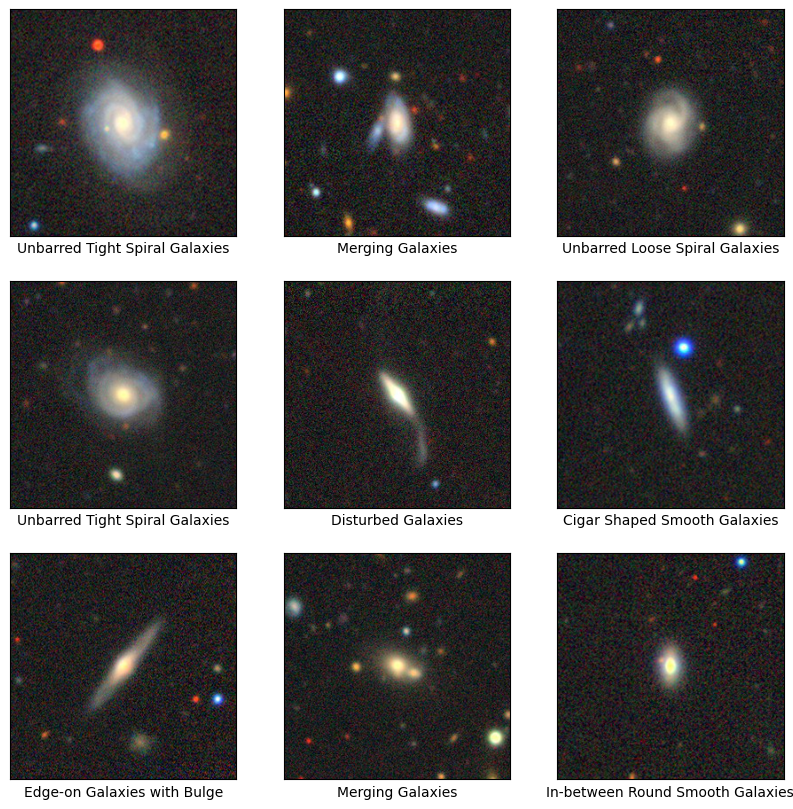

In [18]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i]/255.)
    plt.xlabel(class_labels[int(np.argwhere(labels[i]==1))])
plt.show()

In [19]:
show_datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1/255.,
)
show_datagen.fit(images)

In [20]:
def mixup(batch_x, batch_y, alpha):
    batch_size = len(batch_x)
    lam = np.random.beta(alpha, alpha, size=batch_size)

    index = np.random.permutation(batch_size)
    mixed_x = lam.reshape(batch_size, 1, 1, 1) * batch_x + (1 - lam.reshape(batch_size, 1, 1, 1)) * batch_x[index]
    mixed_y = lam.reshape(batch_size, 1) * batch_y + (1 - lam.reshape(batch_size, 1)) * batch_y[index]

    return mixed_x, mixed_y

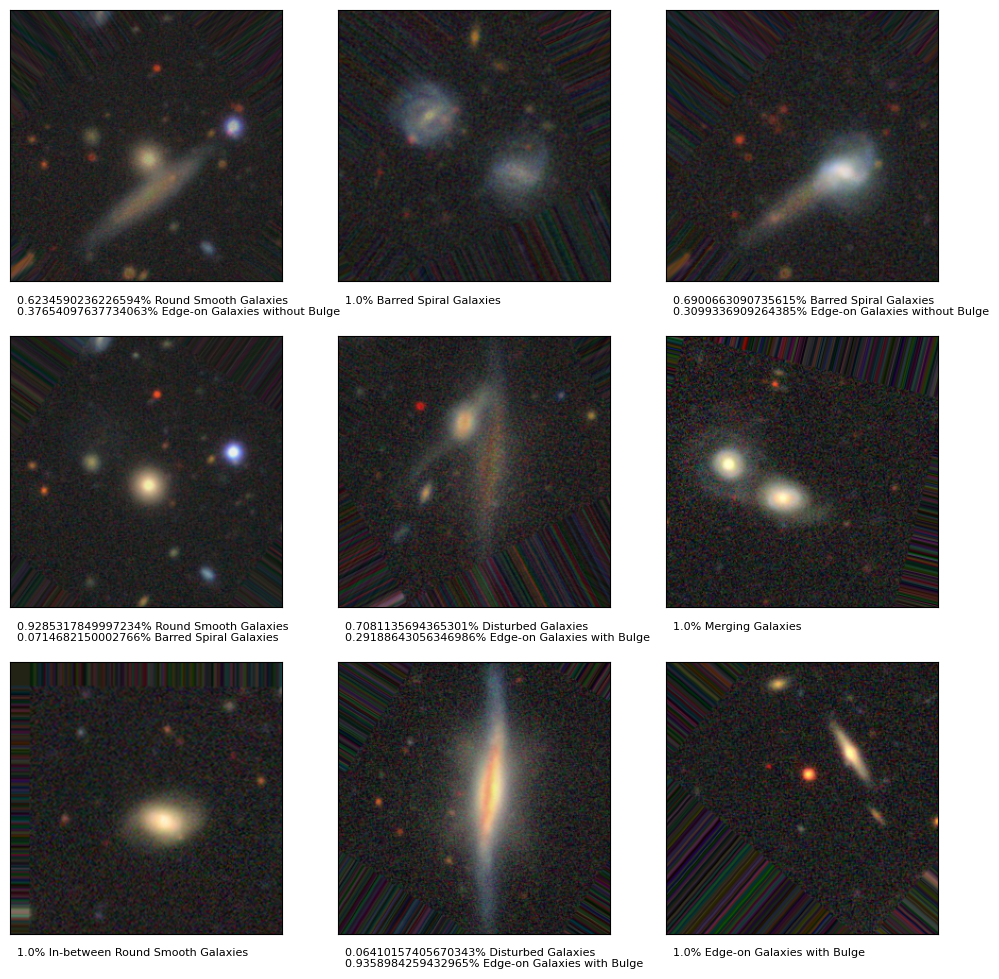

In [21]:
generator = show_datagen.flow(images, labels, batch_size=9)
batch_x, batch_y = next(generator)
mixed_x, mixed_y = mixup(batch_x, batch_y, 1)
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mixed_x[i])
    show_labels = []
    for j in range(10):
        if mixed_y[i][j]!=0:
            show_label = str(mixed_y[i][j])+'% '+class_labels[j]
            show_labels.append(show_label)
    plt.annotate('\n'.join(show_labels), xy=(0, 0), xytext=(5, -10),xycoords='axes fraction', textcoords='offset points',ha='left', va='top', fontsize=8)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1/255.,
    validation_split=0.2,
)

train_datagen.fit(images)

In [ ]:
batch_size = 16

In [ ]:
checkpointer_nomixup = ModelCheckpoint(filepath='modelsave.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)
history_nomixup = model_nomixup.fit(train_datagen.flow(images, labels, batch_size=batch_size,subset='training'),
                                                    validation_data=train_datagen.flow(images, labels,batch_size=batch_size, subset='validation'),
                                                    steps_per_epoch=880,
                                                    epochs=200,
                                                    callbacks=[lr_reducer,checkpointer_nomixup])

In [ ]:
fig1 = plt.figure(num="nomixup", figsize=(8, 6))
ax1 = fig1.add_subplot(111)
ax1.plot(history_nomixup.history['categorical_accuracy'], label='train accuracy', color='b')
ax1.plot(history_nomixup.history['val_categorical_accuracy'], label='val accuracy', color='g')
ax1.legend(loc = 'upper center')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy');
ax2 = ax1.twinx()
ax2.plot(history_nomixup.history['loss'], label="train loss", color='r')
ax2.plot(history_nomixup.history['val_loss'], label="val loss", color='y')
ax2.legend(loc=2)
ax2.set_ylabel('loss');
ax2.legend(loc = 'lower center')
plt.show()

In [ ]:
def datagen_generator(images, labels, batch_size, alpha):
    generator = train_datagen.flow(images, labels, batch_size=batch_size,subset='training')
    while True:
        batch_x, batch_y = next(generator)
        mixed_x, mixed_y = mixup(batch_x, batch_y, alpha)
        yield mixed_x, mixed_y

In [ ]:
alpha = 1

In [ ]:
checkpointer_mixup = ModelCheckpoint(filepath='modelsave_allmixup.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)
history_mixup = model_mixup.fit(datagen_generator(images, labels, batch_size, alpha),
                                                    validation_data=train_datagen.flow(images, labels,batch_size=batch_size, subset='validation'),
                                                    steps_per_epoch=880,
                                                    epochs=200,
                                                    callbacks=[lr_reducer,checkpointer_mixup]
                                                 )


In [ ]:
fig1 = plt.figure(num="mixup", figsize=(8, 6))
ax1 = fig1.add_subplot(111)
ax1.plot(history_mixup.history['categorical_accuracy'], label='train accuracy', color='b')
ax1.plot(history_mixup.history['val_categorical_accuracy'], label='val accuracy', color='g')
ax1.legend(loc = 'upper center')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy');
ax2 = ax1.twinx()
ax2.plot(history_mixup.history['loss'], label="train loss", color='r')
ax2.plot(history_mixup.history['val_loss'], label="val loss", color='y')
ax2.legend(loc=2)
ax2.set_ylabel('loss');
ax2.legend(loc = 'lower center')
plt.show()


In [22]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1/255.,
)
test_datagen.fit(images)

In [23]:
labels_=labels.argmax(axis=1)

In [24]:
predict_nomixup = model_nomixup.predict(test_datagen.flow(images,labels_,shuffle=False)).argmax(axis=1)

2023-10-13 00:53:29.845437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2023-10-13 00:53:31.164771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


555/555 [==============================] - 123s 200ms/step


In [25]:
print(classification_report(labels_, predict_nomixup))

              precision    recall  f1-score   support

           0       0.55      0.18      0.27      1081
           1       0.91      0.88      0.89      1853
           2       0.96      0.91      0.93      2645
           3       0.91      0.95      0.93      2027
           4       0.75      0.86      0.80       334
           5       0.91      0.82      0.86      2043
           6       0.81      0.72      0.76      1829
           7       0.61      0.88      0.72      2628
           8       0.89      0.95      0.92      1423
           9       0.95      0.90      0.92      1873

    accuracy                           0.83     17736
   macro avg       0.82      0.81      0.80     17736
weighted avg       0.84      0.83      0.83     17736



Text(95.72222222222221, 0.5, 'True class')

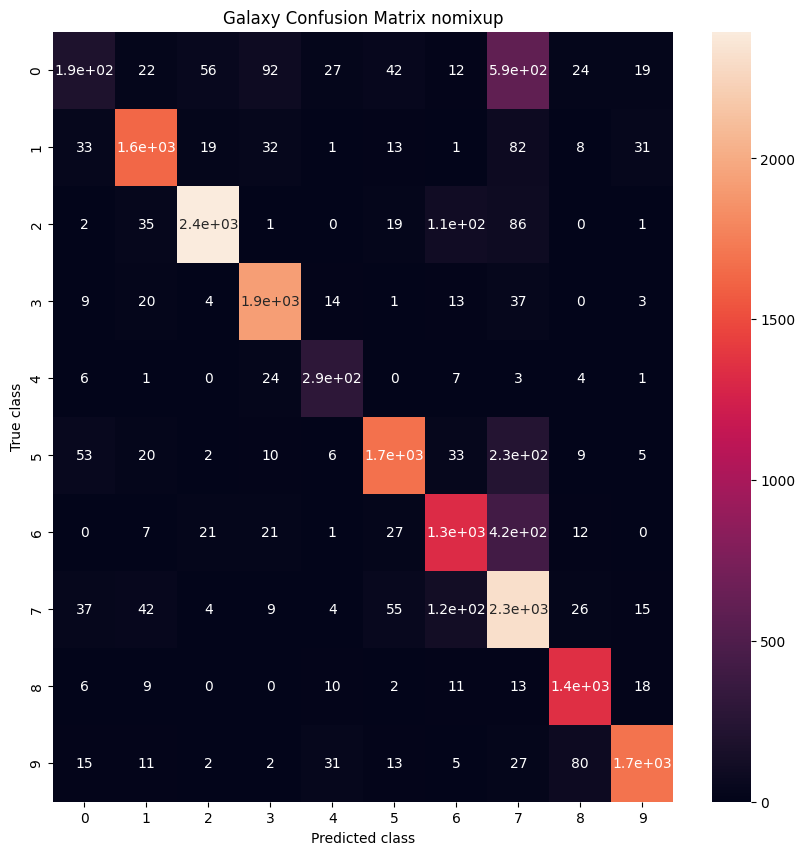

In [26]:
plt.figure(figsize=(10, 10))
matrix_nomixup = confusion_matrix(labels_, predict_nomixup)
sns.heatmap(matrix_nomixup, annot=True)
plt.title('Galaxy Confusion Matrix nomixup')
plt.xlabel('Predicted class')
plt.ylabel('True class')

In [27]:
predict_mixup = model_mixup.predict(test_datagen.flow(images,labels_,shuffle=False)).argmax(axis=1)

555/555 [==============================] - 117s 199ms/step


In [28]:
print(classification_report(labels_, predict_mixup))

              precision    recall  f1-score   support

           0       0.69      0.23      0.35      1081
           1       0.90      0.93      0.91      1853
           2       0.93      0.96      0.94      2645
           3       0.90      0.95      0.92      2027
           4       0.77      0.94      0.84       334
           5       0.85      0.90      0.87      2043
           6       0.83      0.76      0.79      1829
           7       0.70      0.80      0.75      2628
           8       0.91      0.95      0.93      1423
           9       0.96      0.94      0.95      1873

    accuracy                           0.86     17736
   macro avg       0.84      0.84      0.83     17736
weighted avg       0.85      0.86      0.85     17736



Text(95.72222222222221, 0.5, 'True class')

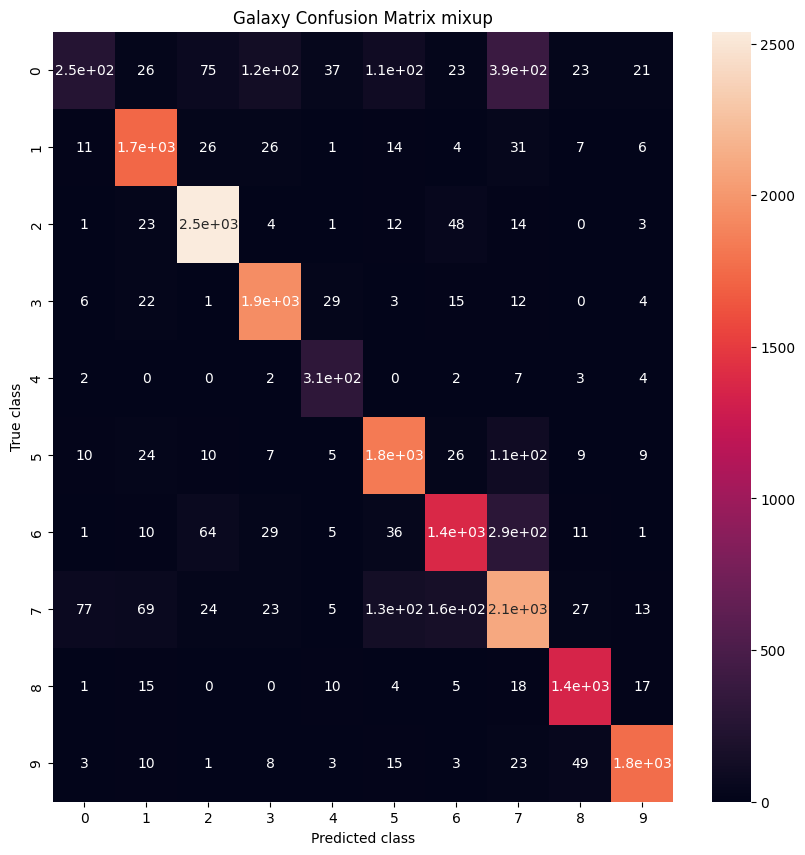

In [29]:
plt.figure(figsize=(10, 10))
matrix_mixup = confusion_matrix(labels_, predict_mixup)
sns.heatmap(matrix_mixup, annot=True)
plt.title('Galaxy Confusion Matrix mixup')
plt.xlabel('Predicted class')
plt.ylabel('True class')